In [1]:
# Pre requisites for this notebook
!pip install Pillow
!pip install nb_black
%load_ext nb_black

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [2]:
import os
from requests import get
from pathlib import Path
import gc
import tensorflow as tf
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.activations import mish

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

np.random.seed(0)

from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force:
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)

<IPython.core.display.Javascript object>

## Download open-payments dataset

In [4]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
font_url = "https://ff.static.1001fonts.net/r/o/roboto-condensed.regular.ttf"

dataset_name = "open-payments"
out = Path(os.getcwd()) / f"data/{dataset_name}/train_bench.csv"
# out_test = Path(os.getcwd()) / f"data/{dataset_name}_test.csv"
out_font = Path(os.getcwd()) / f"RobotoCondensed-Regular.ttf"

# download(url, out)
# download(url_test, out_test)
download(font_url, out_font)

File already exists.


<IPython.core.display.Javascript object>

### Load open-payments as a dataframe

In [5]:
target = "status"
train = pd.read_csv(out, low_memory=False)
print(train.shape)

(73354, 7)


<IPython.core.display.Javascript object>

### Prepare split

In [6]:
train_indices = train[train.Set == "train"].index.values
np.random.shuffle(train_indices)
valid_indices = train[train.Set == "valid"].index.values
test_indices = train[train.Set == "test"].index.values

<IPython.core.display.Javascript object>

### Encode target

In [7]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
Y = (
    label_encoder.fit_transform(train[[target]].values.reshape(-1))
    .reshape(-1, 1)
    .astype("uint8")
)
print(Y.shape)

X = train.drop(columns=[target, "Set"]).values.astype("str")
print(X.shape)

del train
gc.collect()

(73354, 1)
(73354, 5)


0

<IPython.core.display.Javascript object>

In [8]:
# https://he-arc.github.io/livre-python/pillow/index.html#methodes-de-dessin
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
# https://stackoverflow.com/questions/384759/how-to-convert-a-pil-image-into-a-numpy-array
# line = np.array(pic, dtypes="uint8")
# from https://arxiv.org/pdf/1902.02160.pdf page 2

<IPython.core.display.Javascript object>

In [9]:
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)


def word_to_square_image(text, size, cut_length=None):

    truncated = text[:cut_length] if cut_length is not None else text
    max_x = np.ceil(np.sqrt(len(truncated))).astype("int")
    character_size = np.floor(size / max_x).astype("int")
    padding = np.floor((size - (max_x * character_size)) / 2).astype("int")
    # Do we need pt to px conversion ? Seems like not
    # font_size =  int(np.floor(character_size*0.75))
    font_size = character_size

    fnt = ImageFont.truetype(out_font.as_posix(), font_size)
    image = Image.new("RGB", (size, size), BLACK)
    # Obtention du contexte graphique
    draw = ImageDraw.Draw(image)
    x = 0
    y = 0
    for letter in text:
        draw.text(
            (padding + x * character_size, padding + y * character_size),
            letter,
            font=fnt,
            fill=WHITE,
        )
        if x + 1 < max_x:
            x += 1
        else:
            y += 1
            x = 0
    return np.array(image)

<IPython.core.display.Javascript object>

In [10]:
def text_to_square_image(features, image_size=299, cut_length=None):
    square_nb = np.ceil(np.sqrt(len(features))).astype("int")
    word_size = np.floor(image_size / square_nb).astype("int")
    max_features = len(features)
    padding = np.floor((image_size - square_nb * word_size) / 2).astype("int")
    result_image = np.zeros((image_size, image_size, 3), dtype="uint8")
    results = []
    i_feature = 0
    for x in range(0, square_nb):
        if i_feature is None:
            break
        for y in range(0, square_nb):
            i_feature = x * (square_nb) + y
            if i_feature >= max_features:
                i_feature = None
                break
            x_pos = x * word_size + padding
            y_pos = y * word_size + padding
            result_image[
                x_pos : x_pos + word_size, y_pos : y_pos + word_size
            ] = word_to_square_image(
                features[i_feature], size=word_size, cut_length=cut_length
            )
    return result_image

<IPython.core.display.Javascript object>

In [11]:
def preprocess_data(data, map_func):
    preprocessed_df = None
    with PoolExecutor() as executor:
        preprocessed_df = np.stack(list(executor.map(map_func, data)), axis=0)
    print(preprocessed_df.shape)
    print(preprocessed_df.nbytes / (1024 * 1024))  # Memory size in RAM
    gc.collect()
    return preprocessed_df

<IPython.core.display.Javascript object>

In [12]:
def fixed_text_to_square_image(values):
    return text_to_square_image(values, image_size=96, cut_length=None)

<IPython.core.display.Javascript object>

In [13]:
from tensorflow.keras.utils import to_categorical
from concurrent.futures import ProcessPoolExecutor as PoolExecutor


class TabularToImagesDataset:
    def __init__(self, values, target, func, prefetch=1024):
        self.values = values
        self.target = to_categorical(target.reshape(-1))
        assert target.shape[0] == self.values.shape[0]
        self.current = -1
        self.max_prefetch = -1
        self.prefetch_nb = prefetch
        self.func = func
        self.ready = None

    def __iter__(self):
        # print("Calling __iter__")
        self.current = -1
        self.max_prefetch = -1
        return self

    def __call__(self):
        # print("Calling __call__")
        self.current = -1
        self.max_prefetch = -1
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.values.shape[0]

    def prefetch(self):
        if self.ready is not None and self.ready.shape[0] == self.values.shape[0]:
            return
        # print("HERE")
        self.max_prefetch = min(self.current + self.prefetch_nb, self.values.shape[0])
        # if self.current == self.max_prefetch:

        with PoolExecutor() as executor:
            self.ready = np.stack(
                list(
                    executor.map(
                        self.func, self.values[self.current : self.max_prefetch]
                    )
                ),
                axis=0,
            )
        return

    def next(self):
        self.current += 1
        # print(self.current)
        if self.current >= self.values.shape[0]:
            raise StopIteration()
        # self.current = 0
        # self.max_prefetch = -1
        if self.current >= self.max_prefetch:
            # print("Will prefetch")
            self.prefetch()
            # print(self.ready.shape)
        return (
            self.ready[self.current % self.prefetch_nb],
            # text_to_square_image(self.values[self.current]),
            self.target[self.current],
        )

<IPython.core.display.Javascript object>

In [14]:
def build_tf_dataset(X_values, Y_values, image_size, fix_func, prefetch, batch_size):
    gen = TabularToImagesDataset(
        X_values, Y_values, fix_func, prefetch=prefetch * batch_size,
    )
    if prefetch * batch_size > X_values.shape[0]:
        prefetch = np.ceil(X_values.shape[0] / batch_size).astype("int")

    dataset = tf.data.Dataset.from_generator(
        gen,
        (tf.uint8, tf.uint8),
        (tf.TensorShape([image_size, image_size, 3]), tf.TensorShape([2])),
    )

    dataset = dataset.repeat().batch(batch_size)
    return dataset.prefetch(prefetch)

<IPython.core.display.Javascript object>

In [15]:
epochs_1 = 2
epochs_2 = 200
image_size = 96
cut_length = None
BATCH_SIZE = 256
PREFETCH = 100  # 40
# SHUFFLE_BUFFER_SIZE = 10000
patience = 5


def fixed_text_to_square_image(values):
    return text_to_square_image(values, image_size=image_size, cut_length=cut_length)


steps_per_epoch = np.ceil(train_indices.shape[0] / BATCH_SIZE)
steps_per_epoch_val = np.ceil(valid_indices.shape[0] / BATCH_SIZE)

dataset = build_tf_dataset(
    X[train_indices],
    Y[train_indices],
    image_size,
    fixed_text_to_square_image,
    PREFETCH,
    BATCH_SIZE,
)

dataset_valid = build_tf_dataset(
    X[valid_indices],
    Y[valid_indices],
    image_size,
    fixed_text_to_square_image,
    PREFETCH,
    BATCH_SIZE,
)

<IPython.core.display.Javascript object>

In [16]:
activation = mish
optimizer = Lookahead(RectifiedAdam(), sync_period=6, slow_step_size=0.5)

<IPython.core.display.Javascript object>

In [17]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights="imagenet", include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation=activation, kernel_initializer="he_normal")(x)
x = Dropout(0.2)(x)
x = Dense(128, activation=activation, kernel_initializer="he_normal")(x)
x = Dropout(0.2)(x)

# and a logistic layer -- let's say we have 200 classes
# predictions = Dense(200, activation='softmax')(x)
predictions = Dense(2, activation="softmax")(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# es.set_model(model)
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizer, loss="binary_crossentropy")  # , metrics=["AUC"])

<IPython.core.display.Javascript object>

In [18]:
%%time
# train the model on the new data for a few epochs
history_1 = model.fit(
    dataset, 
    #callbacks=[es],
    epochs=epochs_1,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_valid,
    validation_steps=steps_per_epoch_val
)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

Train for 230.0 steps, validate for 29.0 steps
Epoch 1/2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
230/230 [==============================] - 246s 1s/step - loss: 0.2582 - val_loss: 1.2114
Epoch 2/2
230/230 [==============================] - 22s 95ms/step - loss: 0.1962 - val_loss: 0.9448
CPU times: user 1min 46s, sys: 18.1 s, total: 2min 4s
Wall time: 4min 28s


<IPython.core.display.Javascript object>

In [19]:
def plot_metric(history, metric):
    # Plot training & validation loss values
    plt.plot(history.history[metric])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"Model {metric}")
    plt.ylabel(f"{metric}")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc="upper left")
    plt.show()

<IPython.core.display.Javascript object>

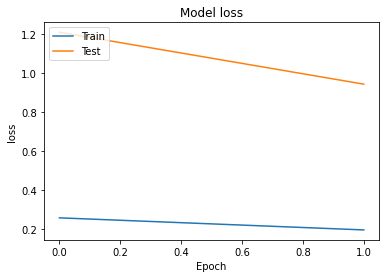

<IPython.core.display.Javascript object>

In [20]:
plot_metric(history_1, "loss")

In [21]:
# plot_metric(history_1, "AUC")

<IPython.core.display.Javascript object>

In [22]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
model.summary()
# for i, layer in enumerate(model.layers):
#    print(i, layer.name)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [23]:
# Let's unfreeze the whole model
for layer in model.layers:
    layer.trainable = True
# Let's build an optimizer
optimizer = Lookahead(RectifiedAdam(), sync_period=6, slow_step_size=0.5)
es = EarlyStopping(
    monitor="val_loss",
    verbose=1,
    mode="min",
    patience=patience,
    restore_best_weights=True,
)
# We need to recompile the model for these modifications to take effect
es.set_model(model)
model.compile(optimizer=optimizer, loss="binary_crossentropy")  # , metrics=["AUC"])

<IPython.core.display.Javascript object>

In [ ]:
%%time
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_2 = model.fit(
    dataset, 
    callbacks=[es],
    epochs=epochs_2,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_valid,
    validation_steps=steps_per_epoch_val
)

Train for 230.0 steps, validate for 29.0 steps
Epoch 1/200
230/230 [==============================] - 148s 645ms/step - loss: 0.1750 - val_loss: 0.1671
Epoch 2/200
230/230 [==============================] - 75s 324ms/step - loss: 0.1498 - val_loss: 0.1390
Epoch 3/200
230/230 [==============================] - 120s 520ms/step - loss: 0.1350 - val_loss: 0.1889
Epoch 4/200
212/230 [==========================>...] - ETA: 6s - loss: 0.1291

In [ ]:
plot_metric(history_2, "loss")

In [ ]:
# plot_metric(history_2, "AUC")

In [ ]:
%%time
valid_data = preprocess_data(X[valid_indices], fixed_text_to_square_image)

In [ ]:
%%time
preds = model.predict(valid_data)
print(roc_auc_score(Y[valid_indices], preds[:, 1]))
del valid_data
gc.collect()

In [ ]:
%%time
test_data = preprocess_data(X[test_indices], fixed_text_to_square_image)

In [ ]:
preds = model.predict(test_data)
print(roc_auc_score(Y[test_indices], preds[:, 1]))
del test_data
gc.collect()

In [ ]:
# https://medium.com/google-developer-experts/interpreting-deep-learning-models-for-computer-vision-f95683e23c1d